In [1]:
#import packages
import tensorflow as tf
from tensorflow.keras import models,layers,Model
import numpy as np
import math,sys,os,glob
import matplotlib.pyplot as plt
import PIL

In [2]:
#load some training images
train_dir = 'D:\\UCI\\AstroInfo\\Alex-April-2020-4k\\ps1dr2ZTF_jpg\\'
filenames = glob.glob('D:\\UCI\\AstroInfo\\Alex-April-2020-4k\\ps1dr2ZTF_jpg\\**\\*.jpg')
dataj = []
for f in filenames:
    with PIL.Image.open(f) as img:
        d = np.asarray(img)
        dataj.append(tf.cast(d[96:160,96:160] / 255., 'float32'))
#split into training and validation datasets
vdataj = dataj[:int(len(dataj)/2)]
tdataj = dataj[int(len(dataj)/2):]
dataj = tf.reshape(dataj, (len(dataj),64,64,3))
vdataj = tf.reshape(vdataj, (len(vdataj),64,64,3))
tdataj = tf.reshape(tdataj, (len(tdataj),64,64,3))

In [8]:
#create the model
m = models.Sequential()
m.add(layers.Conv2D(16, (3,3), padding='same', activation='relu', input_shape=((64,64,3))))
m.add(layers.MaxPooling2D((2,2), padding='same'))
m.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
m.add(layers.MaxPooling2D((2,2), padding='same'))
m.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
m.add(layers.MaxPooling2D((2,2), padding='same'))

m.add(layers.Flatten())
m.add(layers.Dense(512, activation='relu'))
m.add(layers.Dense(64, activation='relu'))
m.add(layers.Dense(512, activation='sigmoid'))
m.add(layers.Dense(2048, activation='sigmoid'))
m.add(layers.Reshape((8,8,32)))

m.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
m.add(layers.UpSampling2D((2,2)))
m.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
m.add(layers.UpSampling2D((2,2)))
m.add(layers.Conv2D(16, (3,3), padding='same', activation='relu'))
m.add(layers.UpSampling2D((2,2)))
m.add(layers.Conv2D(3, (3,3), padding='same', activation='sigmoid'))

m.summary()
m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.losses.mean_squared_error, metrics=['accuracy','mean_squared_error'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)             

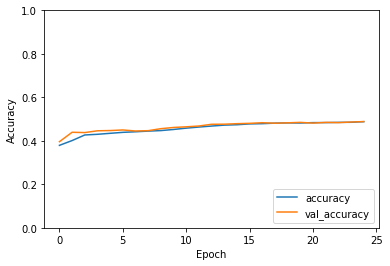

In [9]:
#fit the model to training data
history = m.fit(tdataj, tdataj, epochs=25, verbose=0, validation_data=((vdataj,vdataj)))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

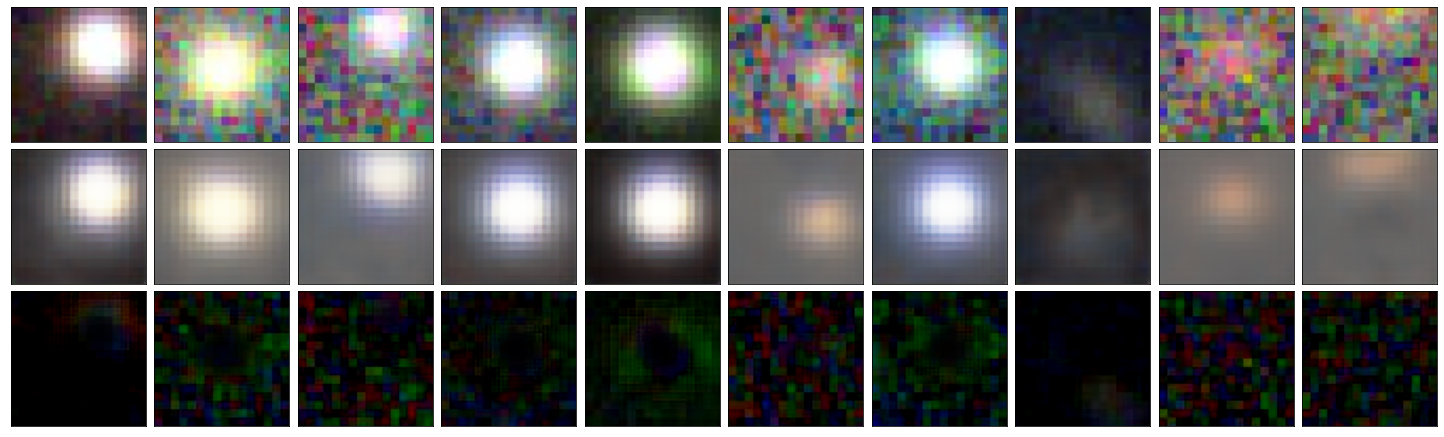

In [10]:
#plot input, output, and difference
fig, axes = plt.subplots(nrows=3, ncols=10, sharex=True, sharey=True, figsize=(20,6))
ins = dataj[:10]
outs = []
for i in ins:
    temp = []
    temp.append(i)
    temp = tf.reshape(temp, (len(temp), 64, 64, 3))
    outs.append(m.call(temp))
resid = []
for x in range(10):
    resid.append(tf.cast(ins[x], "float") - outs[x])
for imgs, row in zip([ins, outs], axes[:2]):
    for img, ax in zip(imgs,row):
        ax.imshow(tf.reshape(img, (64, 64, 3)))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
for img, ax in zip(resid, axes[2]):
    ax.imshow(tf.reshape(img, (64, 64, 3)))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
fig.tight_layout(pad=.5)

In [11]:
#compute the MSE on the input and reconstructed images
def matrix_MSE_J(img):
    return np.square(tf.reshape(img, (64,64,3)) - tf.reshape(m.call(tf.reshape(img, (1,64,64,3))), (64,64,3))).mean(axis=None)

In [12]:
#load confirmed gravitational lens images
disc_lenses_J = glob.glob('D:\\UCI\\AstroInfo\\Alex-April-2020\\ps1dr2BaseLG_jpg\\**\\*.jpg')
lens_data_J = []
for f in disc_lenses_J:
    with PIL.Image.open(f) as img:
        d = np.asarray(img)
        lens_data_J.append(tf.cast(d[96:160,96:160] / 255., 'float32'))

In [13]:
errors_J = []
for i in range(len(dataj)):
    errors_J.append(matrix_MSE_J(dataj[i]))
errors_J = sorted(errors_J)

lens_errors_J = []
for i in range(len(lens_data_J)):
    lens_errors_J.append(matrix_MSE_J(lens_data_J[i]))
lens_errors_J = sorted(lens_errors_J)

In [14]:
#record the errors for future reference
file = open('img_errors_CAE_jpg.txt', 'w')
for e in errors_J:
    file.write(str(e) + '\n')
file.close()
file2 = open('disc_lenses_errors_CAE_jpg.txt', 'w')
for e in lens_errors_J:
    file2.write(str(e) + '\n')
file2.close()